In [8]:
!pip install seaborn

     |████████████████████████████████| 285 kB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 27.2 MB 15.1 MB/s eta 0:00:01    |███████████████████▌            | 16.6 MB 9.9 MB/s eta 0:00:02     |████████████████████▉           | 17.8 MB 9.9 MB/s eta 0:00:01     |██████████████████████████      | 22.1 MB 15.1 MB/s eta 0:00:01


In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

Nous avons décidé de créer une classe Scraper pour rassembler toutes les fonctions dont nous aurons besoin pour scraper le site web que nous avons choisi.

In [21]:
class Scraper:
    def __init__(self, url):
        self.chrome_options = webdriver.ChromeOptions()
        self.chrome_options.add_argument('--no-sandbox')
        self.chrome_options.add_argument('--window-size=1420,1080')
        self.chrome_options.add_argument('--headless')
        self.chrome_options.add_argument('--disable-gpu')
        self.chrome_options.add_argument('--disable-dev-shm-usage')  
        self.driver = webdriver.Chrome(options=self.chrome_options)
        self.url = url
    
    def access_website(self):
        self.driver.get(self.url)
        
    def click_on_by_text(self,text):
        self.driver.find_element_by_link_text(text).click()
    
    def getImage(self):
        return self.driver.find_element_by_css_selector('img.responsive-img').get_attribute('src')
        
    def click_on_by_xpath(self,xpath):
        self.driver.find_element_by_xpath(xpath).click()
    
    def accept_cookies(self):
        self.driver.find_element_by_xpath("//button[text()='Accept']").click()
    
    def getShow(self,results,category):
        all_widgets = self.driver.find_elements_by_class_name("explore-results")
        first_line = all_widgets[0]
        all_first_line_elements = first_line.find_elements_by_class_name('col-inline')
        all_first_line_images = first_line.find_elements_by_css_selector('img.responsive-img')
        for i in range(len(all_first_line_elements)):
            try:
                show = all_first_line_elements[i].split('\n')
                details = show[1].split('•')
                votes_details = details[1].split('(')
                image = all_first_line_images[i].get_attribute('src')
                results.append({'Type': category, 'Nom': show[0], 'Pays': details[0], 'Note': votes_details[0],
                                'Nb_votes': votes_details[1].split(' ')[0]})
            except:
                print(all_first_line_elements[i])
                continue
        return results

    def getAllShows(self,pages,category): 
        results = []
        for i in range(pages):
            try:
                self.getShow(results,category)
                WebDriverWait(self.driver, 20).until(EC.element_to_be_clickable((By.XPATH, "//a[text()='Suivant →']"))).click()
            except:
                continue
        return results
    
    def quitDriver(self):
        self.driver.quit()

In [22]:
chrome = Scraper('https://www.viki.com/?locale=fr')

In [24]:
chrome.access_website()

In [25]:
chrome.accept_cookies()

In [26]:
chrome.click_on_by_text('Explorer')

In [27]:
chrome.click_on_by_text('Tous les spectacles')

In [28]:
chrome.click_on_by_xpath("//span[text()='Tous les types']")

In [29]:
chrome.click_on_by_xpath("//div[text()='Télévision']")

In [30]:
series = chrome.getAllShows(5,'Série')

<selenium.webdriver.remote.webelement.WebElement (session="c976030615d23d9d2841ff2609975599", element="097ccd03-35e7-4e29-8c11-eae0eec1d952")>
<selenium.webdriver.remote.webelement.WebElement (session="c976030615d23d9d2841ff2609975599", element="64379e94-aa2b-44f2-b759-6476ab2ad53a")>
<selenium.webdriver.remote.webelement.WebElement (session="c976030615d23d9d2841ff2609975599", element="2599a474-8231-4e9d-a1a5-bcc65e8a1e73")>
<selenium.webdriver.remote.webelement.WebElement (session="c976030615d23d9d2841ff2609975599", element="888d401a-8c80-456d-a355-e7e54339563d")>
<selenium.webdriver.remote.webelement.WebElement (session="c976030615d23d9d2841ff2609975599", element="eb4cee09-1f47-4125-ab42-4cee3a6b22ed")>
<selenium.webdriver.remote.webelement.WebElement (session="c976030615d23d9d2841ff2609975599", element="9a9fb14a-5bd5-430e-b6a4-17f1bef9efc8")>
<selenium.webdriver.remote.webelement.WebElement (session="c976030615d23d9d2841ff2609975599", element="4ffa7b12-1fc5-4988-b726-637d26ee5807")>

<selenium.webdriver.remote.webelement.WebElement (session="c976030615d23d9d2841ff2609975599", element="a7df6363-9305-456a-aff0-2ae54d5bc190")>
<selenium.webdriver.remote.webelement.WebElement (session="c976030615d23d9d2841ff2609975599", element="1fb01fe9-ebd6-469e-944b-9e023aa47cdb")>
<selenium.webdriver.remote.webelement.WebElement (session="c976030615d23d9d2841ff2609975599", element="98de1928-000c-4bd2-9184-55f267f24aeb")>
<selenium.webdriver.remote.webelement.WebElement (session="c976030615d23d9d2841ff2609975599", element="d3f96538-1d74-471a-b3cc-daf6fc7726cb")>
<selenium.webdriver.remote.webelement.WebElement (session="c976030615d23d9d2841ff2609975599", element="7087b56d-9b76-47af-b81a-2b89750c805b")>
<selenium.webdriver.remote.webelement.WebElement (session="c976030615d23d9d2841ff2609975599", element="2bf7a7b0-1f34-430e-8a46-0f4e2a63b4de")>
<selenium.webdriver.remote.webelement.WebElement (session="c976030615d23d9d2841ff2609975599", element="44009175-3613-40e6-8aaf-5835b2b7d843")>

In [11]:
len(series)

0

In [12]:
chrome.click_on_by_xpath("//span[text()='Télévision']")

In [13]:
chrome.click_on_by_xpath("//div[text()='Films']")

In [14]:
movies = chrome.getAllShows(3,'Film')

In [15]:
len(movies)

49

In [16]:
chrome.quitDriver()

In [17]:
shows = series + movies

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_shows = pd.read_csv('viki_shows.csv')

In [10]:
df_shows['on_air'] = df_shows['Nom'].str.contains("À L'ANTENNE")

In [11]:
df_shows.head()

,Type,Nom,Pays,Note,Nb_votes,on_air
0,Série,The Penthouse,Corée,9.2,24788,False
1,Série,À L'ANTENNE Tu es mon héros,Chine Continentale,9.5,4595,True
2,Série,À L'ANTENNE The Sweet Blood,Corée,8.9,1916,True
3,Série,True Beauty,Corée,9.6,143241,False
4,Série,À L'ANTENNE The Penthouse 2 (Le Penthouse 2),Corée,9.5,13030,True


In [53]:
len(df_shows)

558

In [54]:
df_shows.sort_values('Nom',inplace=True)

In [55]:
df_shows.drop_duplicates(subset ="Nom",keep = False, inplace = True)

In [56]:
len(df_shows)

512

In [22]:
df_shows.to_csv('viki_shows.csv',index=False)

In [2]:
from pymongo import MongoClient

In [3]:
client = MongoClient("mongo")

In [20]:
client.drop_database('viki')

In [6]:
df_shows = pd.read_csv('viki_shows.csv')

In [7]:
df_shows.head()

,Type,Nom,Pays,Note,Nb_votes
0,Série,The Penthouse,Corée,9.2,24788
1,Série,À L'ANTENNE Tu es mon héros,Chine Continentale,9.5,4595
2,Série,À L'ANTENNE The Sweet Blood,Corée,8.9,1916
3,Série,True Beauty,Corée,9.6,143241
4,Série,À L'ANTENNE The Penthouse 2 (Le Penthouse 2),Corée,9.5,13030


In [8]:
df_shows['Nom'] = df_shows['Nom'].str.replace("À L'ANTENNE",'')

In [10]:
viki_shows = df_shows.to_dict(orient='records')

In [4]:
db_viki = client.viki

In [5]:
collection_viki = db_viki['shows']

In [13]:
collection_viki.insert_many(viki_shows)

In [45]:
db_viki.list_collection_names()

['shows']

In [39]:
cursor = collection_viki.find()

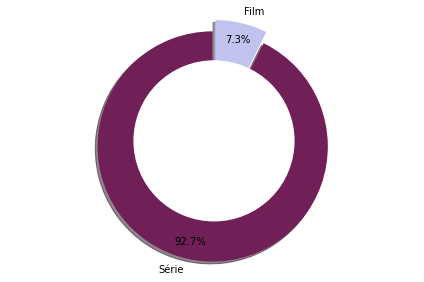

In [63]:
#type série/film
cur = collection_viki.aggregate([{"$group" : {"_id" : "$Type", "TypeShows" : {"$sum" : 1}}}])
res = pd.DataFrame(list(cur))
explode = (0.05, 0.05)
colors = ['#701f57', '#c2c2f0']

fig1, ax1 = plt.subplots()
TypeShows = res['TypeShows']
labels = res['_id']
ax1.pie(TypeShows, explode=explode,labels=labels, pctdistance=0.85,autopct='%1.1f%%', shadow=True, colors = colors, startangle=90)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')
plt.tight_layout()
plt.show()

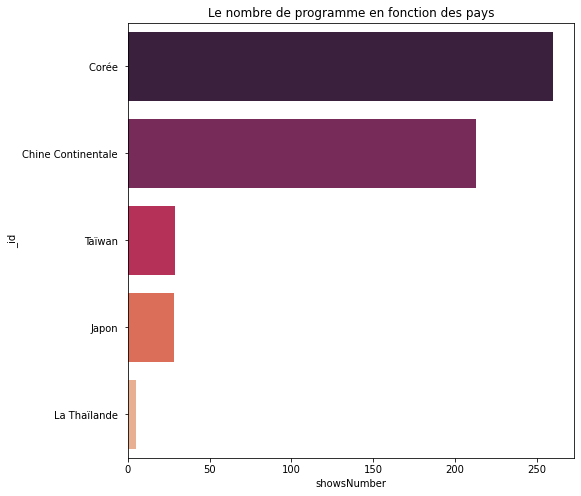

In [41]:
#pays
cur = collection_viki.aggregate([{"$group" : {"_id" : "$Pays", "showsNumber" : {"$sum" : 1}}},{'$sort':{'showsNumber':-1}}])
res = pd.DataFrame(list(cur))
plt.figure( figsize = (8,8) )
plt.title('Le nombre de programme en fonction des pays')
sns.barplot(x='showsNumber',y='_id',data=res,palette='rocket')
plt.show()

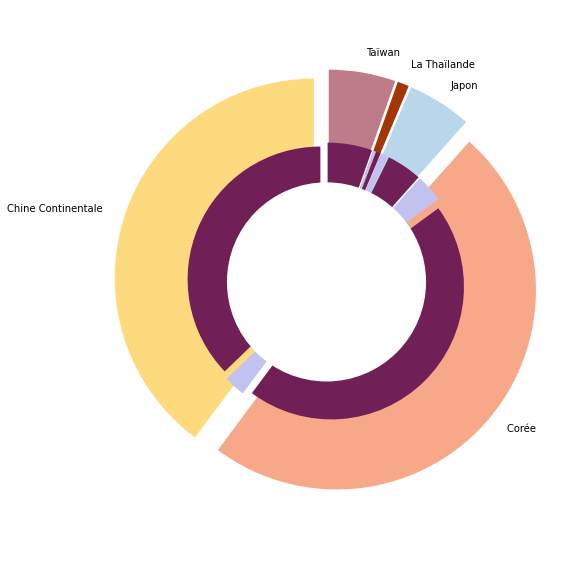

In [161]:
cur_total = collection_viki.aggregate([{"$group" : {"_id" : "$Pays", "showsNumber" : {"$sum" : 1}}},{'$sort':{'showsNumber':-1}}])
res_total = pd.DataFrame(list(cur_total))
res_total.sort_values('_id', inplace=True)
cur_repart = collection_viki.aggregate([{"$group" : {"_id" : {"pays":"$Pays","type":"$Type"},"showsNumber" : {"$sum" : 1}}},{'$sort':{'showsNumber':-1}}])
res_repart = pd.DataFrame(list(cur_repart))
res_repart = pd.concat([res_repart.drop(['_id'], axis=1), res_repart['_id'].apply(pd.Series)], axis=1)
res_repart.sort_values('pays', inplace=True)
labels_total = res_total['_id']
labels_repart = res_repart['type']
sizes_total = res_total['showsNumber']
sizes_repart = res_repart['showsNumber']
explode_total = (0.2,0.2,0.2,0.2,0.2)
explode_repart = (0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1)
colors_total = ['#feda7e', '#f7a889', '#bad6eb', '#a03704', '#be7c89']
colors_repart = ['#701f57', '#c2c2f0','#701f57', '#c2c2f0','#701f57', '#c2c2f0','#701f57', '#c2c2f0','#701f57', '#c2c2f0']
plt.pie(sizes_total,labels=labels_total,colors=colors_total,startangle=90,frame=True,explode=explode_total,radius=3)
plt.pie(sizes_repart,colors=colors_repart,startangle=90,explode=explode_repart,radius=2)
centre_circle = plt.Circle((0,0),1.5,color='black',fc='white',linewidth=0)
fig = plt.gcf()
fig.set_size_inches(8,8)
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.tight_layout()
plt.show()

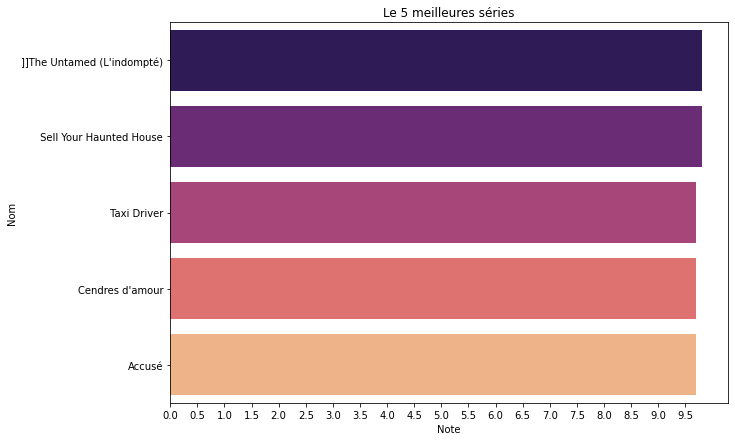

In [51]:
#5 mieux notés
cur = collection_viki.find({'Type':'Série'}).sort('Note',-1).limit(5)
res = pd.DataFrame(list(cur))
plt.figure( figsize = (10,7) )
plt.title('Le 5 meilleures séries')
sns.barplot(x='Note',y='Nom',data=res,palette=("magma"))
plt.xticks(np.arange(0, 10, 0.5))
plt.show()

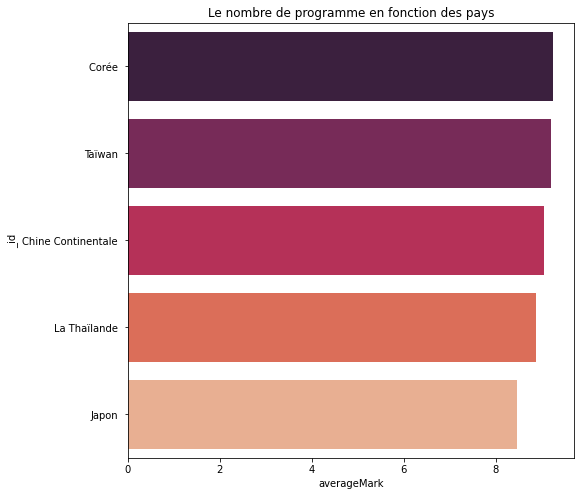

In [45]:
cur = collection_viki.aggregate([{"$group" : {"_id" : "$Pays", "averageMark" : {"$avg" : '$Note'}}},{'$sort':{'averageMark':-1}}])
res = pd.DataFrame(list(cur))
plt.figure( figsize = (8,8) )
plt.title('Le nombre de programme en fonction des pays')
sns.barplot(x='averageMark',y='_id',data=res,palette=("rocket"))
plt.show()

In [19]:
cur = collection_viki.find({'Type':'Film'}).sort('Note',-1).limit(5)
list(cur)

[]

In [159]:
pal = sns.color_palette("ch:s=-.2,r=.6")
pal.as_hex()

['#e3d9c1', '#d4aa9b', '#be7c89', '#965680', '#5f396a', '#27213f']